--------------------
	 Scaling Relation MCMC Fitting Code


Today is: 2022-07-07 12:53:23.313228
--------------------
filename: test_00
Number of points 1318
Very Simple Model took 43.7 seconds



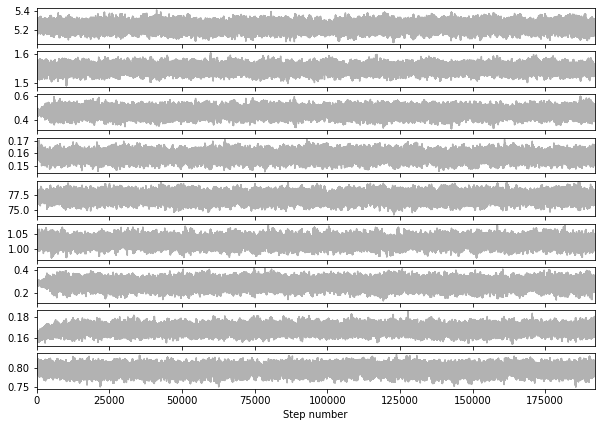

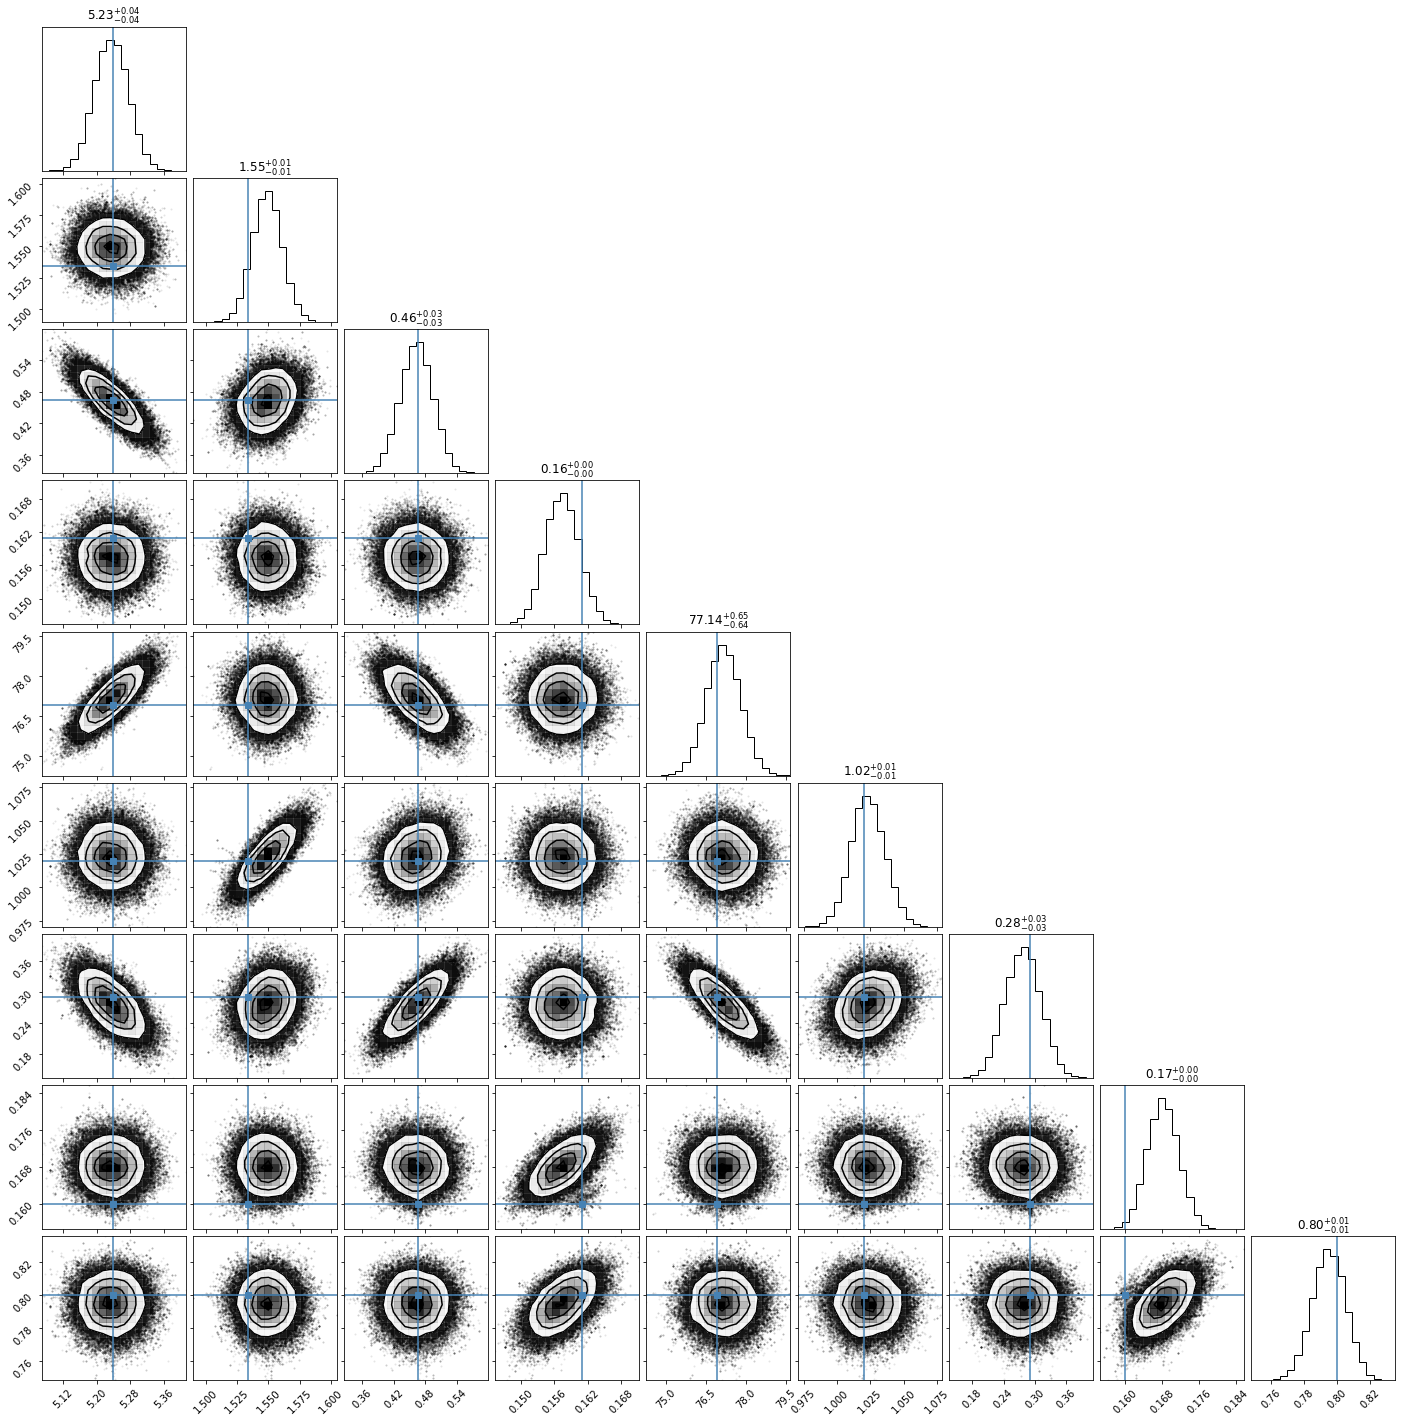

In [1]:
%run run_very_simple_model.py

In [2]:
from __future__ import print_function, division
from IPython.core.display import display, HTML
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from multiprocessing import Pool
cosmology.setCosmology('WMAP9')

import numpy as np
import pandas as pd
import emcee
import pandas as pd
import time
import os
import sys
from scipy.optimize import minimize
import scipy.stats
import math
import matplotlib.pyplot as plt
import pylab as plt
import corner

from colossus.cosmology import cosmology
cosmology.setCosmology('WMAP9')

In [3]:


###############################################################################
################################### Likelihood ################################
###############################################################################

def log_likelihood(theta, indices, eps=1e-9):
    # for each cluster compute the log_likelihood
    # defining variables
    probs = []
    for ix in indices:
        probs.append(log_likelihood_very_simple(theta, ix))
    p = np.array(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

def log_likelihood_very_simple(theta):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
        
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mass, redshift)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass, redshift)
        
    # logNormal Likelihood
    lp_lbd_zeta = compute_log_pLbdZeta(_lambda, zeta,
                                       scatter_lambda, scatter_sze, rho,
                                       ln_lbd_pred, ln_zeta_pred)
        
    return np.nansum(lp_lbd_zeta)

###############################################################################
################################### Prior #####################################
###############################################################################


SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

## gaussian priors on lambda with 3 sigma from the true params
Lambda_Priors = {'A_lambda':[76.9, 3*8.2], 'B_lambda':[1.020, 3*0.080],'C_lambda':[0.23, 3*0.16],
             'scatter_lambda':[0.23, 1.5*0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']


def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

###############################################################################
############################### Posterior #####################################
###############################################################################

# change posterior
#def logposterior_vsp(theta):
    ## OUTPUT (RETURN VALUES) STILL NEEDS TO BE CHANGED ##
#    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
#    if not np.isfinite(lp):
#        return -np.inf, -np.inf
#    ll = lp + log_likelihood_very_simple(theta)
#    if not np.isfinite(ll):
#        return lp, -np.inf
#    return lp + ll, lp
    # return the likeihood times the prior (log likelihood plus the log prior)
 #   return lo, lp

def logposterior_vsp(theta):
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    ll = log_likelihood_very_simple(theta)# + lp
    if not np.isfinite(ll):
        return lp, -np.inf
    return lp + ll, lp

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_chisi(zeta, xi):
    res = np.exp(-(xi-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res

def prob_lbd_hat(x, mean , std):
    res = gaussian(x, mean , std)
    return res

def prob_mass(zeta, mass, z, params):
    params = A_sze, B_sze, C_sze, scatter_sze
    ln_zeta_pred = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass, z)
    ln_prob = -0.5*((np.log(zeta)-ln_zeta_pred)/scatter_sze)**2
    return ln_prob
    
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,1)
    return ilo, iup

def compute_log_pLbdZeta(Lambda, Zeta, scatter_lambda, scatter_sze, rho,
                         ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    # converting std to normal distribution
    s_zeta = scatter_sze
    s_lambda = scatter_lambda
    s_lambda_inv = np.where(s_lambda<=eps, np.inf, 1/s_lambda)
    s_zeta_inv = np.where(s_zeta<=eps, np.inf, 1/s_zeta)
    
    # avoid error messages
    rho2 = (1-rho**2)
    rho_inv = np.where(rho2<=eps, np.inf, 1/rho2)
    
    cov2 = (s_lambda)**(2)*(s_zeta)**(2)*rho2
    additional_cov = (-0.5)*np.log(np.pi*cov2)
        
    lbd_std = (np.log(Lambda) - ln_lbd_pred)*s_lambda_inv
    zeta_std = (np.log(Zeta) - ln_zeta_pred)*s_zeta_inv
    #np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2.

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std
    
    # total likelihood
    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    
    return lp_total_m

from datetime import datetime
# Using current time
time_for_now = datetime.now()

###############################################################################
################################### Starting Code #############################
###############################################################################

### Parameter to name it
runname = "test"
version = 0
filename = "{}_{:02d}".format(runname, version)
print('filename:',filename)
infile = 'fake_data_Jul4.csv'

### Grid Setting
Nzeta = 75
Nlbd = 150
Nmass = 100
Nz = 100
alpha = 0.0001

### MCMC Setup
theta_true = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]
Nburnin = 1000 # number of burn-in samples
Nsamples = 5000 # number of final posterior samples
walkers = 32
ndims = len(theta_true)
guess = (np.array(theta_true)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

### Load Data
df = pd.read_csv(infile)
mask = (df['lambda']>2.)&(df['zeta']>0.)
ix = np.where(mask)[0]
Np = ix.size

# Set Variables
yerr = 0.05*(df['lambda'].to_numpy())
redshift = (np.array(df['z']))[ix]
zeta = (np.array(df['zeta']))[ix]
sz_signal = (np.array(df['chisi']))[ix]
_lambda = (np.array(df['lambda_wo_noise']))[ix]
_lambda_error = (np.array(yerr))[ix]
mass = np.array(df['M'])[ix]

# global variables
M0 = 3e14
Ez0 = E(0)

# set up integration vectors
zvec = np.linspace(np.min(np.array(df['z'])), np.max(np.array(df['z'])), Nz)
mvec = np.logspace(13.8, 15.2, Nmass)
lbdvec = np.linspace(0.8*np.min(np.array(df['lambda'])), 1.2*np.max(np.array(df['lambda'])), Nlbd)
zetavec = np.linspace(1.5, 1.2*np.max(np.array(df['zeta'])), Nzeta)

print('Number of points',Np)
prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, _lambda_i, _lambda_error_i)
                             for _lambda_i, _lambda_error_i in zip(_lambda, _lambda_error)])
prob_chisi_vec = np.array([prob_chisi(zetavec, sz_signal_i) for sz_signal_i in sz_signal])
lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])

# given: mvec, lbdvec and zetavec
# grid of lambda and zeta values to be intregated over
zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')
step = np.where(lbdvec>5.,1.,0.)
    

filename: test_00
Number of points 1318


In [4]:
#def logposterior_vsp(theta):
    ## OUTPUT (RETURN VALUES) STILL NEEDS TO BE CHANGED ##
    # if the prior is not finite return a probability of zero (log probability of -inf)
#    lp = logprior(theta)
#    if not np.isfinite(lp):
#        return -np.inf, -np.inf
    
#    ll = log_likelihood_very_simple(theta) + lp
#    if not np.isfinite(ll):
#        return lp, -np.inf
    
    #return ll, lp
    # return the likeihood times the prior (log likelihood plus the log prior)
    #return lo, lp

#def logposterior_vsp(theta):
#    lp = logprior(theta)
#    if not np.isfinite(lp):
#        return -np.inf, -np.inf
#    ll = log_likelihood_very_simple(theta) + lp
#    if not np.isfinite(ll):
#        return lp, -np.inf
#    return ll, lp

In [5]:
#%run run_very_simple_model.py

In [6]:
#%run run_simple_model.py

In [7]:
#%run run_spt_model.py

In [8]:
coords = np.random.randn(32,9)

print(coords.shape)

#nwalkers, ndim = coords.shape

filename = "very_simple_model_result.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(walkers, ndims)
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior_vsp)

#pool = Pool(processes=40)
#sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior_vsp, pool=pool)


(32, 9)


In [ ]:
max_n = 15000
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(coords, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

In [ ]:
filename = "very_simple_model_result.h5"
reader = emcee.backends.HDFBackend(filename)


tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

In [ ]:
import corner
all_samples = np.concatenate(
     (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
)

print(log_prob_samples)
print(log_prior_samples)

In [ ]:
all_samples.shape

In [ ]:
if quick_fit:
    start = time.time()
    np.random.seed(42)
    nll = lambda *args: -log_likelihood_very_simple(*args)
    initial = theta_true + 0.05 * np.random.randn(9)
    soln = minimize(nll, initial)
    end = time.time()
    vsp_time = end - start
    print("Very Simple Model took {0:.1f} seconds".format(vsp_time))
    
    albd, blbd, clbd, slbd, rho = soln.x[4:]
    
    print("Maximum likelihood estimates:")
    print("Albd = {0:.3f}".format(albd))
    print("Blbd = {0:.3f}".format(blbd))
    print("Clbd = {0:.3f}".format(clbd))
    print("Scatter_lbd = {0:.3f}".format(slbd))
    print("rho: {0:.3f}".format(rho))

## Put the new changes here
if run_mcmc:
    pool = Pool(processes=40)              # start 40 worker processes
    sampler = emcee.EnsembleSampler(walkers, ndims, logposterior_vsp, pool=pool)
    start = time.time()
    sampler.run_mcmc(guess, Nsamples+Nburnin)
    end = time.time()
    vsp_mcmc_time = end - start
    print("Very Simple Model took {0:.1f} seconds\n".format(vsp_mcmc_time))
    
    flat_samples = sampler.flatchain
    fig, axes = plt.subplots(ndims, figsize=(10, 7), sharex=True)
    samples = flat_samples
    for i in range(ndims):
        ax = axes[i]
        ax.plot(samples[:, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        #ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("Step number");
    
    fig = corner.corner(flat_samples, truths=theta_true, show_titles = True);